In [2]:
import cvxpy as cp
import numpy as np
numpy = np
import scipy
import math, cmath
import time
import pickle
import datetime

import matplotlib.pyplot as plt 

from find_denominator_commons import *

from IPython.display import display, clear_output

In [3]:
# dimensions
'''
   ┌───┐         ┌───┐
─dx│ N │──da*db──│ S │db─
   └───┘         └───┘
'''
dx = 2
da = 2
db = 2
dy = da * db
dz = db

d_memory = 1
d_subx = dx // d_memory
d_suby = dy // d_memory

dw = dx
dr = da

sigma_x = np.array([[0,1],[1,0]], dtype=complex)
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.diag([1,-1])

def fidelity(a, b): # squared fidelity
    try:
        return np.trace(sqrtmh(sqrtmh(a) @ b @ sqrtmh(a))) ** 2
    except ValueError:
        return np.nan

ket0 = np.array([[1], [0]], dtype=complex)
ket1 = np.array([[0], [1]], dtype=complex)
ketp = np.array([[1], [1]], dtype=complex) / math.sqrt(2)
ketm = np.array([[1], [-1]], dtype=complex) / math.sqrt(2)
ketpi = np.array([[1], [1j]], dtype=complex) / math.sqrt(2)
ketmi = np.array([[1], [-1j]], dtype=complex) / math.sqrt(2)

In [4]:
ketbra0 = ket0 @ ket0.conj().T
ketbra1 = ket1 @ ket1.conj().T
ketbrap = ketp @ ketp.conj().T
ketbram = ketm @ ketm.conj().T
ketbrapi = ketpi @ ketpi.conj().T
ketbrami = ketmi @ ketmi.conj().T

In [5]:
def apply_channel_choi(choi, gamma):
    din = gamma.shape[0]
    dout = round(choi.shape[0] / din)
    C_gamma = np_partial_trace(choi @ np.kron(np.eye(dout), gamma.T), [dout, din], 1)
    return C_gamma

def identity_choi(d):
    return unitary_choi(np.eye(d))

def V_to_R(N_xy, V):
    sqrt_N_xy = sqrtmh(N_xy)

    N_xb = np_partial_trace(N_xy, [dx, db, da], 2)
    inv_sqrt_N_xb = powmh(N_xb, -1/2)

    K = sqrt_N_xy @ V @ np.kron(inv_sqrt_N_xb, np.eye(da))
    R_as_kraus = K.reshape((dx, db*da, dx, db, da)).transpose((0,2,3,1,4)).reshape((dx*dx*db*db*da, da))
    R_as_choi = R_as_kraus @ R_as_kraus.conj().T # 1 dx, 2 dx, 3 db, 4 db * da
    return R_as_choi
def apply_choi_inout(C, rho):
    din = rho.shape[0]
    assert din == rho.shape[1]
    dout = C.shape[0] // din
    assert C.shape[0] == din * dout and C.shape[1] == din * dout
    return np_partial_trace_single(C @ kron(rho.T, np.eye(dout)), [din, dout], 0)

def np_apply_supermap(supermap, channel, d1, d2, d3, d4):
    return np_partial_trace(supermap @ kron(np.eye(d1), channel.T, np.eye(d4)), [d1, d2 * d3, d4], 1)

def Petz_outin(choi, gamma):
    din = gamma.shape[0]
    dout = round(choi.shape[0] / din)
    return np_swap_systems(Petz(choi, gamma), [dout, din], 0, 1)

def compare_std_super(prior_choi_server_inout, prior_state, real_choi_server_inout, retro_supermap_inout, real_states, fidelity_function=fidelity):
    prior_result = apply_choi_inout(prior_choi_server_inout, prior_state)
    trace_A = kron(identity_choi(dz), np.eye(da))
    petz = Petz_outin(trace_A, prior_result)
    real_choi_server = np_swap_systems(real_choi_server_inout, [dx, dz*da], 0, 1) # in_out to out_in
    traced_real_choi_server = compose_choi(trace_A, real_choi_server, dz, dz * da, dx)
    compute_and_correct = compose_choi(petz, traced_real_choi_server, dz * da, dz, dx)
    supermap_corrected_channel = np_apply_supermap(retro_supermap_inout, np_swap_systems(traced_real_choi_server, [dz, dx], 0, 1), dx, dx, dz, dz * da)
    
    std_Petz_sum_fidelity = 0
    super_Petz_sum_fidelity = 0
    for real_state in real_states:
        corrected_result = apply_channel_choi(compute_and_correct, real_state)
        true_correct_result = apply_channel_choi(real_choi_server, real_state)
        std_Petz_sum_fidelity += fidelity_function(corrected_result, true_correct_result)

        super_corrected_result = apply_choi_inout(supermap_corrected_channel, real_state)
        super_Petz_sum_fidelity += fidelity_function(super_corrected_result, true_correct_result)
    
    return (std_Petz_sum_fidelity / len(real_states), super_Petz_sum_fidelity / len(real_states))

def compare_std_super_real_state_prior(prior_choi_server_inout, prior_state, real_choi_server_inout, retro_supermap_inout, real_states, fidelity_function=fidelity):

    trace_A = kron(identity_choi(dz), np.eye(da))
    real_choi_server = np_swap_systems(real_choi_server_inout, [dx, dz*da], 0, 1) # in_out to out_in
    traced_real_choi_server = compose_choi(trace_A, real_choi_server, dz, dz * da, dx)
    supermap_corrected_channel = np_apply_supermap(retro_supermap_inout, np_swap_systems(traced_real_choi_server, [dz, dx], 0, 1), dx, dx, dz, dz * da)
    
    std_Petz_sum_fidelity = 0
    super_Petz_sum_fidelity = 0
    for real_state in real_states:
        state_result = apply_choi_inout(prior_choi_server_inout, real_state)
        petz = Petz_outin(trace_A, state_result)
        assert np.allclose(apply_channel_choi(petz, apply_channel_choi(trace_A, state_result)), state_result)
        compute_and_correct = compose_choi(petz, traced_real_choi_server, dz * da, dz, dx)
        corrected_result = apply_channel_choi(compute_and_correct, real_state) # standard Petz using real state as prior
        
        true_correct_result = apply_channel_choi(real_choi_server, real_state)
        std_Petz_sum_fidelity += fidelity_function(corrected_result, true_correct_result)

        super_corrected_result = apply_choi_inout(supermap_corrected_channel, real_state)
        super_Petz_sum_fidelity += fidelity_function(super_corrected_result, true_correct_result)
    
    return (std_Petz_sum_fidelity / len(real_states), super_Petz_sum_fidelity / len(real_states))

def fidelity_super(real_choi_server_inout, retro_supermap_inout, real_states, fidelity_function=fidelity):
    trace_A = kron(identity_choi(dz), np.eye(da))
    real_choi_server = np_swap_systems(real_choi_server_inout, [dx, dz*da], 0, 1) # in_out to out_in
    traced_real_choi_server = compose_choi(trace_A, real_choi_server, dz, dz * da, dx)
    supermap_corrected_channel = np_apply_supermap(retro_supermap_inout, np_swap_systems(traced_real_choi_server, [dz, dx], 0, 1), dx, dx, dz, dz * da)
    
    super_Petz_sum_fidelity = 0
    for real_state in real_states:
        true_correct_result = apply_channel_choi(real_choi_server, real_state)
        super_corrected_result = apply_choi_inout(supermap_corrected_channel, real_state)
        super_Petz_sum_fidelity += fidelity_function(super_corrected_result, true_correct_result)
    
    return super_Petz_sum_fidelity / len(real_states)
    

In [6]:
def cp_apply_supermap(supermap, channel, d1, d2, d3, d4):
    return cp.partial_trace(supermap @ kron(np.eye(d1), channel.T, np.eye(d4)), [d1, d2 * d3, d4], 1)
    
def cp_apply_choi_inout(C, rho):
    din = rho.shape[0]
    assert din == rho.shape[1]
    dout = C.shape[0] // din
    assert C.shape[0] == din * dout and C.shape[1] == din * dout
    return cp.partial_trace(C @ kron(rho.T, np.eye(dout)), [din, dout], 0)

def cp_fidelity(rho, sigma):
    X = cp.Variable(rho.shape, complex=True)
    constraints = [cp.bmat([[rho, X], [X.H, sigma]]) >> 0]
    target = cp.real(cp.trace(X))
    variables = [X]
    return target, constraints, variables

def optimized_super(real_choi_server_inout, real_states, initial_value = None):
    real_choi_server = np_swap_systems(real_choi_server_inout, [dx, dz*da], 0, 1) # in_out to out_in
    trace_A = kron(identity_choi(dz), np.eye(da))
    traced_real_choi_server = compose_choi(trace_A, real_choi_server, dz, dz * da, dx)
    retro_supermap_inout = cp.Variable((dx * dx * dz * dz * da, dx * dx * dz * dz * da), hermitian=True)
    constraints = [retro_supermap_inout >> 0, 
                   superchannel_project(retro_supermap_inout, dx, dx, dz, dz*da) == retro_supermap_inout,
                   cp.trace(retro_supermap_inout) == dx * dz
                  ] # positive + valid supermap
    supermap_corrected_channel = cp_apply_supermap(retro_supermap_inout, np_swap_systems(traced_real_choi_server, [dz, dx], 0, 1), dx, dx, dz, dz * da)
    print(supermap_corrected_channel.shape) ###
    super_Petz_sum_fidelity = 0
    for real_state in real_states:
        true_correct_result = apply_channel_choi(real_choi_server, real_state)
        super_corrected_result = cp_apply_choi_inout(supermap_corrected_channel, real_state)
        #super_Petz_sum_fidelity += cp.trace(true_correct_result @ super_corrected_result) ### not fidelity
        fid_target, fid_constraints, fid_variables = cp_fidelity(true_correct_result, super_corrected_result)
        super_Petz_sum_fidelity += fid_target
        constraints += fid_constraints
    objective = cp.real(super_Petz_sum_fidelity) / len(real_states)
    prob = cp.Problem(cp.Maximize(objective), constraints)
    if not initial_value is None:
        retro_supermap_inout.value = initial_value
        #print("initial value set, initial objective = {0}".format(fidelity_super(real_choi_server_inout, initial_value, real_states)))
    prob.solve(warm_start=not initial_value is None)
    return prob, retro_supermap_inout

def optimized_super_multi(real_chois_inout, real_states, weights=None, initial_value = None):
    retro_supermap_inout = cp.Variable((dx * dx * dz * dz * da, dx * dx * dz * dz * da), hermitian=True)
    constraints = [retro_supermap_inout >> 0, 
                   superchannel_project(retro_supermap_inout, dx, dx, dz, dz*da) == retro_supermap_inout,
                   cp.trace(retro_supermap_inout) == dx * dz
                  ] # positive + valid supermap
    if weights is None:
        weights = np.ones(len(real_chois_inout))
    objective = 0
    for (choi_i, real_choi_server_inout) in enumerate(real_chois_inout):
        real_choi_server = np_swap_systems(real_choi_server_inout, [dx, dz*da], 0, 1) # in_out to out_in
        trace_A = kron(identity_choi(dz), np.eye(da))
        traced_real_choi_server = compose_choi(trace_A, real_choi_server, dz, dz * da, dx)
        supermap_corrected_channel = cp_apply_supermap(retro_supermap_inout, np_swap_systems(traced_real_choi_server, [dz, dx], 0, 1), dx, dx, dz, dz * da)
        super_Petz_sum_fidelity = 0
        for real_state in real_states:
            true_correct_result = apply_channel_choi(real_choi_server, real_state)
            super_corrected_result = cp_apply_choi_inout(supermap_corrected_channel, real_state)
            #super_Petz_sum_fidelity += cp.trace(true_correct_result @ super_corrected_result) ### not fidelity
            fid_target, fid_constraints, fid_variables = cp_fidelity(true_correct_result, super_corrected_result)
            super_Petz_sum_fidelity += fid_target
            constraints += fid_constraints
        objective += cp.real(super_Petz_sum_fidelity) / len(real_states) * weights[choi_i]
    objective /= len(real_chois_inout)
    prob = cp.Problem(cp.Maximize(objective), constraints)
    if not initial_value is None:
        retro_supermap_inout.value = initial_value
        #print("initial value set, initial objective = {0}".format(fidelity_super(real_choi_server_inout, initial_value, real_states)))
    prob.solve(warm_start=not initial_value is None)
    return prob, retro_supermap_inout


In [7]:
def compare3_better_Petz_with_trivial(n_p, prior_channel, retro_super_method, real_channel, states):
    #n_p = 20
    spc_p = n_p - 1
    pmin = 1/n_p
    pmax = 1
    p_list = np.linspace(pmin, pmax, spc_p + 1)
    results = np.zeros((spc_p + 1, spc_p + 1, 3))
    for i, p in enumerate(p_list):
        prior_channel_p = prior_channel(p)
        retro_super_method_p = retro_super_method(p)
        for j, real_p in enumerate(p_list):
            results[i,j,0], results[i,j,1] = compare_std_super_real_state_prior(prior_channel_p, std_Petz_prior_state, real_choi_server_inout = real_channel(real_p), 
                                             retro_supermap_inout = retro_super_method_p, real_states=states)
            results[i,j,2] = sum(fidelity(apply_choi_inout(real_channel(real_p), state), apply_choi_inout(prior_channel(p), state)) for state in states) / len(states)
    return results

In [8]:
titles = [r'Standard Petz recovery $\sigma_{\rm rec} = (\mathcal{R}^{\mathrm{Tr}_A,\Gamma(\gamma)} \circ \mathrm{Tr}_A \circ \mathcal{N})(\rho)$',
          r'Supermap retrodiction recovery $\sigma_{\rm rec} = \mathcal{R}^{\mathcal{S},\Gamma}(\mathcal{S}(\mathcal{N}))(\rho)$',
          r'Optimized supermap recovery $\sigma_{\rm rec} = \mathcal{R}_{\rm optiaml}^{\mathcal{S},\Gamma}(\mathcal{S}(\mathcal{N}))(\rho)$',
         ]
title_trivial = r'Trivial supermap recovery $\sigma_{\rm rec} = \Gamma(\rho)$'
titles_better_Petz = r'Standard Petz recovery $\sigma_{\rm rec} = (\mathcal{R}^{\mathrm{Tr}_A,\Gamma(\rho)} \circ \mathrm{Tr}_A \circ \mathcal{N})(\rho)$'

gate_label_prefix = r'$\Gamma(\rho)='
gate_label_suffix = '$'
CNOT_label = gate_label_prefix + r'(D_p \circ \mathrm{CNOT})(\rho \otimes |0\rangle\langle0|)' + gate_label_suffix
SWAP_label = gate_label_prefix + r'(D_p \circ \mathrm{SWAP})(\rho \otimes |0\rangle\langle0|)' + gate_label_suffix
identity_label = gate_label_prefix + r'D_p(\rho \otimes |0\rangle\langle0|)' + gate_label_suffix

### shorter versions
titles = [r'Standard Petz recovery $\sigma_{\rm rec}^1$',
          r'\rm Supermap retrodiction $\sigma_{\rm rec}^3$',
          r'Optimized supermap recovery $\sigma_{\rm rec}^?$',
         ]
title_trivial = r'\rm Trivial supermap $\sigma_{\rm rec}^2$'
titles_better_Petz = r'\rm Standard Petz $\sigma_{\rm rec}^1$'

CNOT_label = r'$\Gamma_{p,\mathrm{CNOT}}$'
SWAP_label = r'$\Gamma_{p,\mathrm{SWAP}}$'
identity_label = r'$\Gamma_{p,\mathrm{id}}$'

CNOT_label = r'\mathrm{CNOT}'
SWAP_label = r'\mathrm{SWAP}'
identity_label = r'\mathrm{id}'

def plot_compare(results, prior_label = 'prior p', real_label='real p', titles = [], saveto=None):
    n_p = results.shape[0]
    spc_p = n_p - 1
    pmin = 1/n_p
    pmax = 1
    p_list = np.linspace(pmin, pmax, spc_p + 1)
    
    plt.rcParams['text.usetex'] = True
    n_plots = results.shape[2]
    array = [None] * n_plots
    for j in range(n_plots):
        array[j] = results[:, :, j].T
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(2.8 * n_plots, 2.8))  # 1 row, 2 columns
    
    n_rows, n_cols = array[0].shape
    dist_x = (pmax - pmin) / (n_cols - 1)  # Spacing between columns
    dist_y = (pmax - pmin) / (n_rows - 1)  # Spacing between rows
    extent = [pmin - dist_x / 2, pmax + dist_x / 2, pmin - dist_y / 2, pmax + dist_y / 2]  # Adjusted extent
    
    # x_label = r'\rm$p$ in reference channel ' + prior_label
    # y_label = r'\rm$p$ in real channel ' + real_label
    x_label = r'\rm Prior channel $\Gamma_{x,' + prior_label + r'}$'
    y_label = r'\rm True channel $\Gamma_{y,' + prior_label + r'}$'
    label_fontsize = 12
    countour_levels = [0.5,0.6,0.7,0.8,0.85,0.9,0.95,0.98]
    
    im = [None] * n_plots
    
    vmin = 0.45
    vmax = 1
    for j in range(n_plots):
        im[j] = axes[j].imshow(array[j], cmap='viridis', origin='lower', extent=extent)
        axes[j].set_title(titles[j], fontsize=12)
        axes[j].set_xlabel(x_label, fontsize=label_fontsize)
        if j == 0: # only first has y label
            axes[j].set_ylabel(y_label, fontsize=label_fontsize)
        im[j].set_clim(vmin, vmax)  # Set the same color limits for both heatmaps
        
        contours = axes[j].contour(p_list, p_list, array[j], levels=countour_levels, colors='white', linewidths=0.5)
        axes[j].clabel(contours, inline=True, inline_spacing=10, fontsize=8, fmt="%.2f")  # Add labels to contours
    
    # Add a shared colorbar to the figure
    cbar = fig.colorbar(im[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(r'\rm Fidelity of recovery $F(\sigma_{\rm rec},\sigma_{\rm ideal})$', fontsize=label_fontsize)  # Label for the colorbar
    
    # Display the figure
    #plt.tight_layout()  # Adjust layout to prevent overlap
    if not saveto is None:
        plt.savefig(saveto)
        print('plot saved to {0}'.format(saveto))
    plt.show()

### Case 1: $N_{xy}(\rho) = D_p(\mathrm{CNOT}(\rho \otimes |0\rangle\langle 0|))$
Solution:
$$t = \frac{\sqrt{8/p-7} + 1}{2/p - 1}$$
$$V= \exp\left[i \theta Y(2,5)\right],~~ \cos 2\theta =  \frac{\sqrt{8/p-7} -(2/p-2)}{2/p - 1} = t-1$$

In [10]:
def Dp_CNOT(p):    
    N_xy = kraus_to_choi_inout(np.array([[1,0],
                                         [0,0],
                                         [0,0],
                                         [0,1]])
                              )

    N_xy = compose_choi(N_xy, depolarizing_channel(dy, p), dx, dy, dy)
    return N_xy

Gamma_1 = Dp_CNOT
Y25 = np.zeros((8,8), dtype=complex)
Y25[2,5] = -1j
Y25[5,2] = 1j

def p_to_V_case1(p):
    def p_to_theta_exact(p):
        return 1/2 * math.acos((math.sqrt(8 / p - 7) - (2 / p - 2)) / (2 / p - 1))
    V = scipy.linalg.expm(-1j * p_to_theta_exact(p) * Y25)
    return V

def p_to_K_case1(p):
    N_xy = Gamma_1(p)
    sqrt_N_xy = sqrtmh(N_xy)
    N_xb = np_partial_trace(N_xy, [dx, db, da], 2)
    inv_sqrt_N_xb = powmh(N_xb, -1/2)
    V = p_to_V_case1(p)
    K = sqrt_N_xy @ V @ np.kron(inv_sqrt_N_xb, np.eye(da))
    return K

def super_Petz_Dp_CNOT(p):
    return V_to_R(Gamma_1(p), p_to_V_case1(p))
#print_mat(super_Petz_Dp_CNOT(p))

In [11]:
states = [ketbra0, ketbra1, ketbrap, ketbram, ketbrapi, ketbrami, ]
std_Petz_prior_state = np.eye(dx) / dx

### Case 2: $N_{xy}(\rho) = D_p(\mathrm{SWAP}(\rho \otimes |0\rangle\langle 0|))$
Solution:
$$t = \frac{\sqrt{8/p-7} + 1}{2/p - 1}$$
$$V = \exp\left[i(\pi |4\rangle\langle4| +a Y(2,7) + (\pi-a) Y(3,6)\right], ~~\cos a= \frac12 \sqrt{2-t}, ~~\cos2a = -\frac{t}{2}$$

In [13]:
def Gamma_SWAP(p):
    N_xy = kraus_to_choi_inout(np.array([[1,0],
                                         [0,1],
                                         [0,0],
                                         [0,0]])
                              )

    N_xy = compose_choi(N_xy, depolarizing_channel(dy, p), dx, dy, dy)
    return N_xy
Dp_SWAP = Gamma_SWAP

def V_SWAP_exact_minus(p):
    x = math.sqrt(p) / math.sqrt(8 - 7 * p)
    theta = math.acos(x) / 2
    a = math.cos(theta)
    b = math.sin(theta)
    phi = math.atan2(b * (x + 1), a * (x - 1))
    ph = cmath.exp(1j * (2 * phi + math.pi))
    V = np.array([[  0,    a, 0, 0, 1j*b, 0, 0, 0],
                  [  0,    0, 0, 0,    0, 1, 0, 0],
                  [  0,    0, 0, 0,    0, 0, 0, 1],
                  [  0,    0, 0, 1,    0, 0, 0, 0],
                  [ ph,    0, 0, 0,    0, 0, 0, 0],
                  [  0, 1j*b, 0, 0,    a, 0, 0, 0],
                  [  0,    0, 0, 0,    0, 0, 1, 0],
                  [  0,    0, 1, 0,    0, 0, 0, 0]], dtype=complex)
    return V

def super_Petz_Dp_SWAP(p):
    return V_to_R(Gamma_SWAP(p), V_SWAP_exact_minus(p))

### Case 3: identity $N_{xy}(\rho) = D_p(\rho \otimes |0\rangle\langle 0|)$
Solution:

$$\sin\theta = \sqrt{\frac{\sqrt{p}+\sqrt{8-7p}}{2\sqrt{4-3p}}}, ~ \cos\theta = \sqrt{1-\sin^2\theta}$$

In [15]:
def R_identity(V, p):
    N_xy = Gamma_identity(p)
    sqrt_N_xy = sqrtmh(N_xy)

    N_xb = np_partial_trace(N_xy, [dx, db, da], 2)
    inv_sqrt_N_xb = powmh(N_xb, -1/2)

    K = sqrt_N_xy @ V @ np.kron(inv_sqrt_N_xb, np.eye(da))
    R_as_kraus = K.reshape((dx, db*da, dx, db, da)).transpose((0,2,3,1,4)).reshape((dx*dx*db*db*da, da))
    R_as_choi = R_as_kraus @ R_as_kraus.conj().T # 1 dx, 2 dx, 3 db, 4 db * da
    return R_as_choi

def Gamma_identity(p):
    N_xy = kraus_to_choi_inout(np.array([[1,0],
                                         [0,0],
                                         [0,1],
                                         [0,0]])
                              )

    N_xy = compose_choi(N_xy, depolarizing_channel(dy, p), dx, dy, dy)
    return N_xy

Dp_identity = Gamma_identity

def p_to_V_identity2(p):
    sqrt = math.sqrt
    cos2theta = 1 - (sqrt(p) + sqrt(8 - 7*p)) / sqrt(4 - 3*p)
    theta = math.acos(cos2theta) / 2
    s = math.sin(theta)
    c = math.cos(theta)
    V = np.array([
                  [  0,    1, 0, 0,    0, 0, 0, 0],
                  [  0,    0, 0, s,    c, 0, 0, 0],
                  [  1,    0, 0, 0,    0, 0, 0, 0],
                  [  0,    0, 1, 0,    0, 0, 0, 0],
                  [  0,    0, 0, 0,    0, 0, 1, 0],
                  [  0,    0, 0, 0,    0, 1, 0, 0],
                  [  0,    0, 0, 0,    0, 0, 0, 1],
                  [  0,    0, 0, c,   -s, 0, 0, 0],], dtype=complex)
    return V
    
def super_Petz_Dp_identity(p):
    return V_to_R(Gamma_identity(p), p_to_V_identity2(p))

## Compare with standard Petz
### CNOT

In [17]:
number_of_p = 40 # resolution of final figures

C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,0], results[i,j,1] = compare_std_super_real_state_prior(prior_channel_p, std_Petz_prior_state, real_choi_server_inout = real_channel(real_p),
C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,2] = sum(fidelity(apply_choi_inout(real_channel(real_p), state), apply_choi_inout(prior_channel(p), state)) for state in states) / len(states)


plot saved to CNOT_better_Petz_trivial.pdf


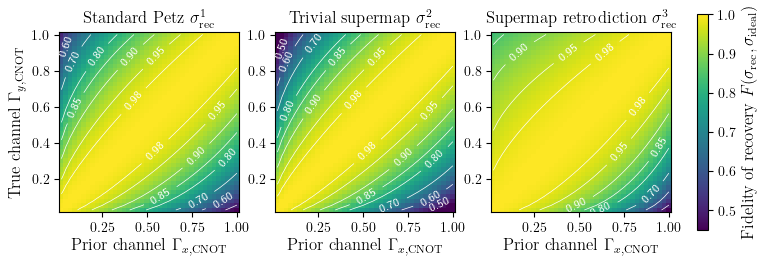

In [24]:
results_CNOT = compare3_better_Petz_with_trivial(number_of_p, prior_channel = Dp_CNOT, retro_super_method = super_Petz_Dp_CNOT, real_channel = Dp_CNOT, states=states)
plot_compare(results_CNOT[:,:,[0,2,1]], 
             prior_label=CNOT_label, real_label=CNOT_label,
             titles=[titles_better_Petz, title_trivial, titles[1]], saveto='CNOT_better_Petz_trivial.pdf')

### SWAP

C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,0], results[i,j,1] = compare_std_super_real_state_prior(prior_channel_p, std_Petz_prior_state, real_choi_server_inout = real_channel(real_p),
C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,2] = sum(fidelity(apply_choi_inout(real_channel(real_p), state), apply_choi_inout(prior_channel(p), state)) for state in states) / len(states)


plot saved to SWAP_better_Petz_trivial.pdf


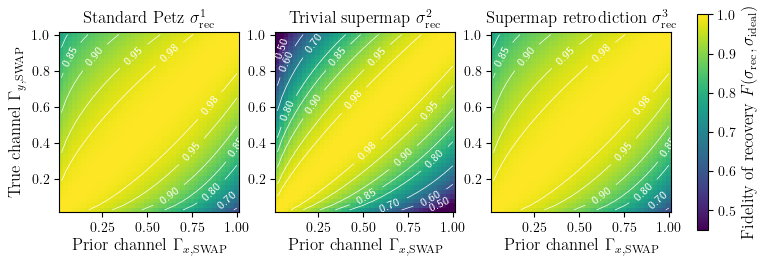

In [26]:
results_SWAP = compare3_better_Petz_with_trivial(number_of_p, prior_channel = Dp_SWAP, retro_super_method = super_Petz_Dp_SWAP, real_channel = Dp_SWAP, states=states)

plot_compare(results_SWAP[:,:,[0,2,1]], 
             prior_label=SWAP_label, real_label=SWAP_label,
             titles=[titles_better_Petz, title_trivial, titles[1]], saveto='SWAP_better_Petz_trivial.pdf')

In [27]:
max_diff = 0
for x in range(results_SWAP.shape[0]):
    for y in range(results_SWAP.shape[1]):
        t = results_SWAP[:,:,[0,2,1]][x,y,0] - results_SWAP[:,:,[0,2,1]][x,y,2]
        if abs(t) > max_diff:
            max_diff = abs(t)
max_diff

np.float64(2.3314683517128287e-14)

### Identity

C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,0], results[i,j,1] = compare_std_super_real_state_prior(prior_channel_p, std_Petz_prior_state, real_choi_server_inout = real_channel(real_p),
C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,2] = sum(fidelity(apply_choi_inout(real_channel(real_p), state), apply_choi_inout(prior_channel(p), state)) for state in states) / len(states)


plot saved to identity_better_Petz_trivial.pdf


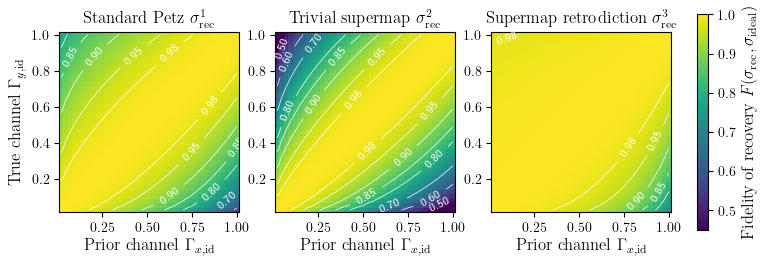

In [29]:
results_identity = compare3_better_Petz_with_trivial(number_of_p, prior_channel = Dp_identity, retro_super_method = super_Petz_Dp_identity, real_channel = Dp_identity, states=states)

plot_compare(results_identity[:,:,[0,2,1]], 
             prior_label=identity_label, real_label=identity_label,
             titles=[titles_better_Petz, title_trivial, titles[1]], saveto='identity_better_Petz_trivial.pdf')

### Prior CNOT, true SWAP

C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,0], results[i,j,1] = compare_std_super_real_state_prior(prior_channel_p, std_Petz_prior_state, real_choi_server_inout = real_channel(real_p),
C:\Users\bg199\AppData\Local\Temp\ipykernel_21452\3200891690.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  results[i,j,2] = sum(fidelity(apply_choi_inout(real_channel(real_p), state), apply_choi_inout(prior_channel(p), state)) for state in states) / len(states)


plot saved to CNOT_SWAP_better_Petz_trivial.pdf


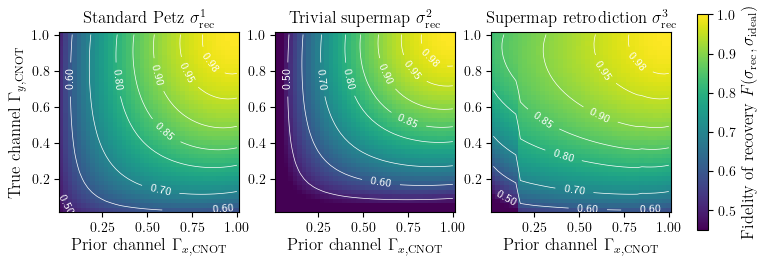

In [31]:
results_CNOT_SWAP = compare3_better_Petz_with_trivial(number_of_p, prior_channel = Dp_CNOT, retro_super_method = super_Petz_Dp_CNOT,
                                                      real_channel = Dp_SWAP, states=states)
plot_compare(results_CNOT_SWAP[:,:,[0,2,1]], 
             prior_label=CNOT_label, real_label=SWAP_label,
             titles=[titles_better_Petz, title_trivial, titles[1]], saveto='CNOT_SWAP_better_Petz_trivial.pdf')